In [16]:
import re
import random
import pandas as pd
import hashlib

In [17]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [18]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Powershell,28.657703,1.364653,21
"CDK Global Ransomeware, June 2024",146.962017,24.493669,6
Finance Junk,208.686572,26.085822,8
Azure OpenAI,287.278702,95.759567,3
Dataverse Queries,382.238289,95.559572,4
Azure AI Foundry,392.081032,26.138735,15
Dataverse Plugins,653.243258,93.320465,7
AKS,673.350338,84.168792,8
pandas,705.683406,88.210426,8
Conditional Access,731.201151,104.457307,7


# Histogram

24219.40


<Axes: >

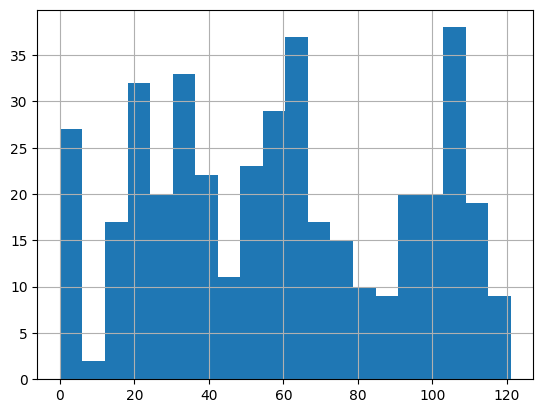

In [19]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [20]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [21]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# Headers with fewest notes first

In [22]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# Focus on one header

In [23]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [24]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [25]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Headers with greatest age sum first

In [26]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [27]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [28]:
n=5
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
existing_cards.head(10)

remake_card_document(existing_cards=existing_cards)

Cards found: 410


## Age max

In [29]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

In [30]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
0,Python,"In Python, you can compare sequences of the sa...",d44782380f6e441bc4bd22c2220ec075,-116.908091,89.099512,116.908091,-1781.990234,0.749416,0,0
1,Python,Many popular machine learning algorithms and d...,6c83d1ec0c1f3bc504757ba5f50c5ba7,-115.469344,89.099512,116.908091,-1781.990234,0.749416,1,0
2,Python,The load_tests() function in Python’s unittest...,bf8051e965fae944e857b5bbc9bbbd58,-113.322285,89.099512,116.908091,-1781.990234,0.749416,2,0
3,Python,"To make a class iterable, you need to define t...",5615edc653c26ebe34f68b16e61f38fa,-113.280268,89.099512,116.908091,-1781.990234,0.749416,3,0
4,Python,Sessions are used to persist parameters across...,b0159957e08e2a7a5dfa8507183ef3dc,-110.532105,89.099512,116.908091,-1781.990234,0.749416,4,0
5,Search Engine Optimization,A website crawler is a tool that systematicall...,0413b01682fb63e6a62dbabf36291cd6,-81.650943,70.648208,81.650943,-1766.205203,0.170495,0,0
6,Search Engine Optimization,SEOquake is a browser extension that provides ...,d7914640266665f7eb3726d2cace41c7,-80.952720,70.648208,81.650943,-1766.205203,0.170495,1,0
7,Search Engine Optimization,Bing Webmaster Tools is a free service by Bing...,28e56b7bb48b874c49f19efca33cd838,-79.658510,70.648208,81.650943,-1766.205203,0.170495,2,0
8,Search Engine Optimization,SEO Spider by Screaming Frog is a website craw...,562fbb1ae762c1527436cd445e761f69,-79.008902,70.648208,81.650943,-1766.205203,0.170495,3,0
9,Search Engine Optimization,The Mobile-Friendly Test is a tool by Google t...,95ba123a7b427ba01c773c4d73cf9725,-77.707152,70.648208,81.650943,-1766.205203,0.170495,4,0
